In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Set seed for reproducibility
np.random.seed(1)

# Model definition
N = 50  # number of individuals (IDs)
tfull = np.array([8, 16, 24, 48, 72])  # planned sampling times (in [h])
pMissing = 0.1  # probability that an observation is missing
nfull = len(tfull)  # number of planned samples

# Individual sampling times
t_obs = []
for i in range(N):
    t_i = tfull[np.random.binomial(n=1, p=1-pMissing, size=nfull).astype(bool)].astype(float)  # missing samples
    t_i += np.random.normal(size=len(t_i))  # actual sampling time
    t_obs.append(t_i)


# Look at the first few IDs
print("First few sampling times:", t_obs[:3])

# Covariate distribution
BWref = 80
BWsd = 15
BW = np.random.normal(loc=BWref, scale=BWsd, size=N)

# CYP2C9 alleles according to reported frequencies
pCYP2C9Alleles = np.array([81.4, 11.2, 7.4]) / 100
CYP2C9 = np.random.multinomial(n=2, pvals=pCYP2C9Alleles, size=N)

# Dosing scheme
D = 3  # [mg]
route = "oral"

# Hyperparameters
fe = {'ka': 0.2,  # [1/h]
      'Vd': 14.3,  # [L]
      'CL1': 0.174,  # [L/h]
      'CL2': 0.0879,  # [L/h]
      'CL3': 0.0422}  # [L/h]
sd_re = {'Vd': 0.054,  # unitless
          'CL': 0.089}  # unitless
sd_ruv = 0.099  # [mg/L], error on log-scale

# Individual parameters affected by covariates
theta = np.empty((N, 3))  # Vd, CL, ka
for i in range(N):
    relbw = BW[i] / 70
    theta[i, 0] = fe['Vd'] * relbw * np.random.lognormal(mean=0, sigma=sd_re['Vd'])
    theta[i, 1] = (fe['CL1'] * CYP2C9[i, 0] +
                   fe['CL2'] * CYP2C9[i, 1] +
                   fe['CL3'] * CYP2C9[i, 2]) * relbw**0.75 * np.random.lognormal(mean=0, sigma=sd_re['CL'])
    theta[i, 2] = fe['ka']

# ODE right-hand side
def rhs(y, t, param):
    dX = np.zeros(2)
    dX[0] = -param['ka'] * y[0]  # gut
    dX[1] = param['ka'] * y[0] - param['CL'] / param['Vd'] * y[1]  # plasma
    return dX


# Solving ODE and computing model prediction
y_pred = []
for i in range(N):
    theta_i = {'Vd': theta[i, 0], 'CL': theta[i, 1], 'ka': theta[i, 2]}
    x0 = [D, 0]  # initial conditions: gut, plasma
    t_combined = np.concatenate(([0], t_obs[i]))  # include dosing time as initial condition
    x_sol = odeint(rhs, x0, t_combined, args=(theta_i,))  # ODE solution
    y_pred.append(x_sol[1:, 1] / theta_i['Vd'])  # concentration


First few sampling times: [array([ 6.89406492, 14.34548455, 21.6365314 , 49.13534535, 70.98298586]), array([ 8.63736181, 15.6775828 , 23.61594565, 49.13376944, 70.90010873]), array([ 8.53381091, 15.9080267 , 25.91382039, 48.33079713, 73.14194252])]


First few rows of the data frame:
     ID       time     y_obs  dose route
0    1   0.000000       NaN   3.0  oral
1    1   6.894065  0.166996   NaN   NaN
2    1  14.345485  0.189599   NaN   NaN
3    1  21.636531  0.176303   NaN   NaN
4    1  49.135345  0.110454   NaN   NaN
5    1  70.982986  0.075021   NaN   NaN
6    2   0.000000       NaN   3.0  oral
7    2   8.637362  0.141739   NaN   NaN
8    2  15.677583  0.141471   NaN   NaN
9    2  23.615946  0.120665   NaN   NaN
10   2  49.133769  0.062366   NaN   NaN
11   2  70.900109  0.035027   NaN   NaN
12   3   0.000000       NaN   3.0  oral
13   3   8.533811  0.115524   NaN   NaN
14   3  15.908027  0.115867   NaN   NaN
15   3  25.913820  0.094653   NaN   NaN
16   3  48.330797  0.053957   NaN   NaN
17   3  73.141943  0.028630   NaN   NaN
18   4   0.000000       NaN   3.0  oral
19   4   6.870405  0.098603   NaN   NaN


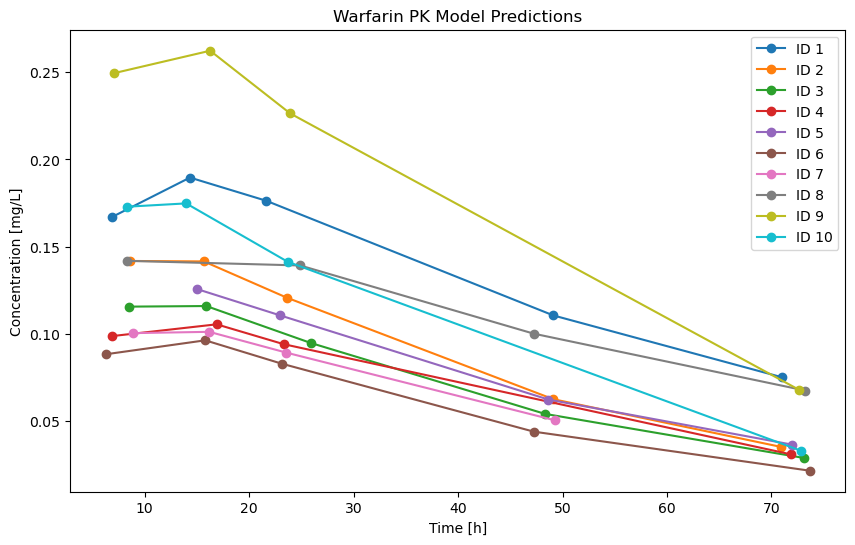

In [5]:

# Hierarchical data
nobs = [len(obs) for obs in t_obs]
df = pd.DataFrame({
    'ID': np.repeat(np.arange(1, N+1), nobs),
    'time': np.concatenate(t_obs),
    'y_obs': np.concatenate([pred * np.random.lognormal(mean=0, sigma=sd_ruv) for pred in y_pred]),
    'dose': np.nan,
    'route': np.nan
})

# Add dosing information
dosing_info = pd.DataFrame({
    'ID': np.arange(1, N+1),
    'time': np.zeros(N),
    'y_obs': np.nan,
    'dose': D,
    'route': route
})
df = pd.concat([df, dosing_info]).sort_values(by=['ID', 'time']).reset_index(drop=True)

# Peek at the data
print("First few rows of the data frame:\n", df.head(20))

# Visualization (subset of individuals for easier visualization)
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(df[df['ID'] == i+1]['time'], df[df['ID'] == i+1]['y_obs'], marker='o', label=f'ID {i+1}')
plt.xlabel('Time [h]')
plt.ylabel('Concentration [mg/L]')
plt.title('Warfarin PK Model Predictions')
plt.legend()
plt.show()

# Write to CSV
df.to_csv('../../data/hamberg-warfarin-pk.csv', index=False)
